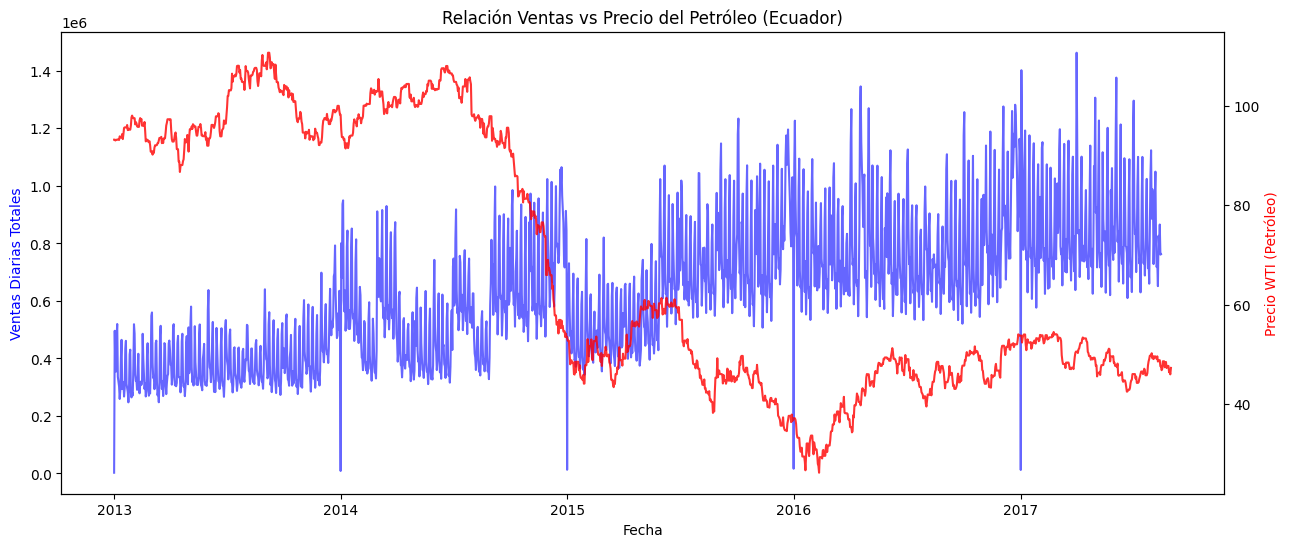

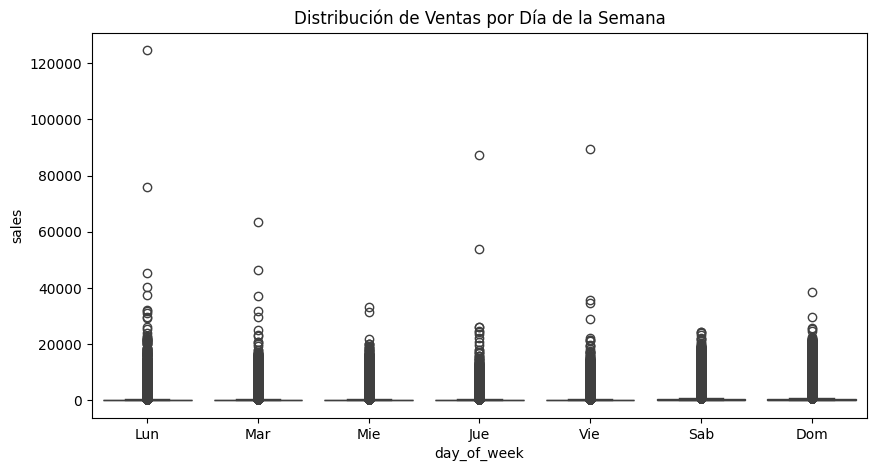

✅ EDA inicial completado. Datos cargados y visualizaciones generadas.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configuración de rutas
PATH_RAW = "../data/raw/"

# 1. Limpieza y preparación del precio del Petróleo (Oil)
oil = pd.read_csv(f"{PATH_RAW}oil.csv", parse_dates=["date"])
oil = oil.set_index("date").resample("D").mean().reset_index()
oil["dcoilwtico"] = oil["dcoilwtico"].ffill().bfill()

# 2. Carga de Train y Merge con Oil
train = pd.read_csv(f"{PATH_RAW}train.csv", parse_dates=["date"])
train = train.merge(oil, on="date", how="left")


# 3. Feature Engineering inicial
def create_date_features(df):
    df["month"] = df["date"].dt.month
    df["day_of_week"] = df["date"].dt.dayofweek
    df["year"] = df["date"].dt.year
    df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)
    return df


train = create_date_features(train)

# 4. Visualización: Ventas vs Petróleo
fig, ax1 = plt.subplots(figsize=(15, 6))
ax2 = ax1.twinx()

daily_sales = train.groupby("date")["sales"].sum().reset_index()
ax1.plot(
    daily_sales["date"], daily_sales["sales"], color="blue", alpha=0.6, label="Ventas"
)
ax2.plot(oil["date"], oil["dcoilwtico"], color="red", alpha=0.8, label="Petróleo")

ax1.set_xlabel("Fecha")
ax1.set_ylabel("Ventas Diarias Totales", color="blue")
ax2.set_ylabel("Precio WTI (Petróleo)", color="red")
plt.title("Relación Ventas vs Precio del Petróleo (Ecuador)")
plt.show()

# 5. Estacionalidad Semanal
plt.figure(figsize=(10, 5))
sns.boxplot(data=train, x="day_of_week", y="sales")
plt.title("Distribución de Ventas por Día de la Semana")
plt.xticks(ticks=range(7), labels=["Lun", "Mar", "Mie", "Jue", "Vie", "Sab", "Dom"])
plt.show()

print("✅ EDA inicial completado. Datos cargados y visualizaciones generadas.")

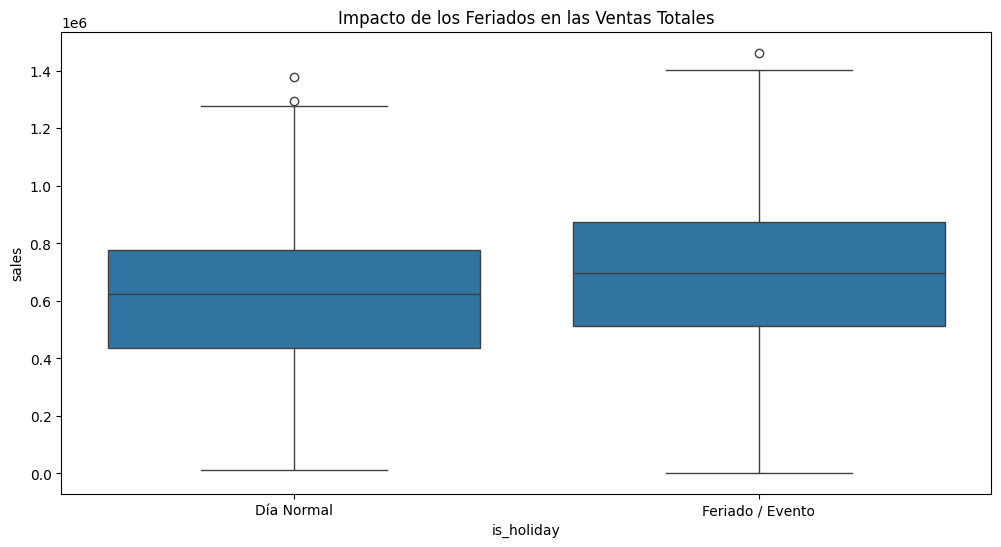

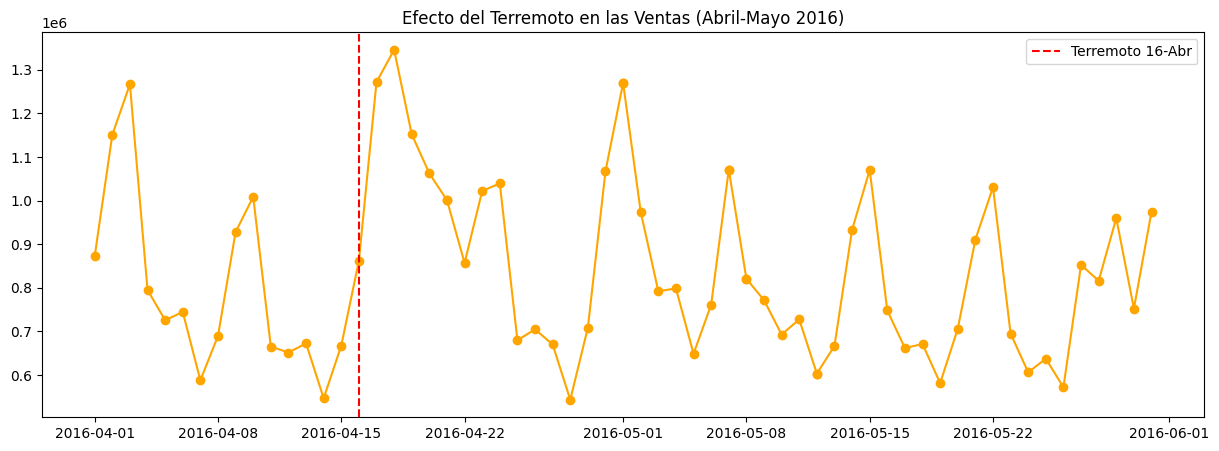

In [ ]:
# 1. Carga de Feriados
holidays = pd.read_csv(f"{PATH_RAW}holidays_events.csv", parse_dates=["date"])

# Filtrar solo feriados que no fueron transferidos (los transferidos no afectan el día original)
holidays = holidays[holidays["transferred"] == False]

# 2. Cruzar ventas diarias con feriados
daily_sales = train.groupby("date")["sales"].sum().reset_index()
daily_sales = daily_sales.merge(
    holidays[["date", "type", "description"]], on="date", how="left"
)

# Crear una bandera (flag) de si es feriado
daily_sales["is_holiday"] = daily_sales["type"].notnull().astype(int)

# 3. Visualización: Impacto de Feriados en Ventas
plt.figure(figsize=(12, 6))
sns.boxplot(data=daily_sales, x="is_holiday", y="sales")
plt.title("Impacto de los Feriados en las Ventas Totales")
plt.xticks([0, 1], ["Día Normal", "Feriado / Evento"])
plt.show()

# 4. Análisis del Terremoto (Abril 2016)
# El terremoto fue el 16 de abril de 2016. Veamos el comportamiento semanas después.
terremoto_period = daily_sales[
    (daily_sales["date"] >= "2016-04-01") & (daily_sales["date"] <= "2016-05-31")
]

plt.figure(figsize=(15, 5))
plt.plot(
    terremoto_period["date"], terremoto_period["sales"], marker="o", color="orange"
)
plt.axvline(
    pd.Timestamp("2016-04-16"), color="red", linestyle="--", label="Terremoto 16-Abr"
)
plt.title("Efecto del Terremoto en las Ventas (Abril-Mayo 2016)")
plt.legend()
plt.show()

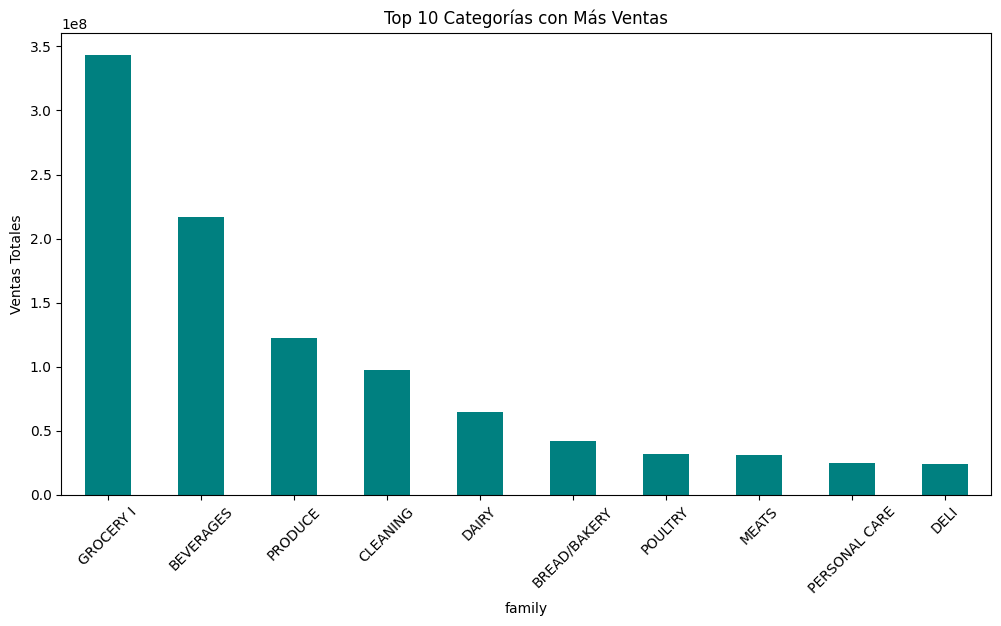

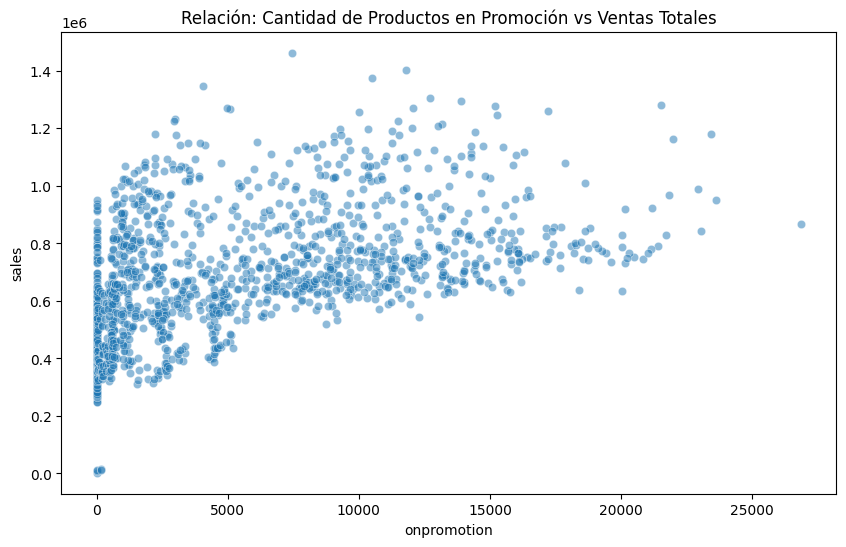

Correlación Promoción-Ventas: 0.57


In [ ]:
# 1. Ventas por Familia de Producto (Top 10)
family_sales = (
    train.groupby("family")["sales"].sum().sort_values(ascending=False).head(10)
)

plt.figure(figsize=(12, 6))
family_sales.plot(kind="bar", color="teal")
plt.title("Top 10 Categorías con Más Ventas")
plt.ylabel("Ventas Totales")
plt.xticks(rotation=45)
plt.show()

# 2. Correlación entre Promociones y Ventas
# Tomamos una muestra o agrupamos por día para no saturar la memoria
promo_impact = train.groupby("date")[["sales", "onpromotion"]].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=promo_impact, x="onpromotion", y="sales", alpha=0.5)
plt.title("Relación: Cantidad de Productos en Promoción vs Ventas Totales")
plt.show()

print(
    f"Correlación Promoción-Ventas: {promo_impact['sales'].corr(promo_impact['onpromotion']):.2f}"
)